**Author:** Chinenye Nwagbaraji
This notebook validates the trained CNN model by loading saved weights, evaluating its performance on the test dataset, and visualizing accuracy and loss metrics.
***This script was developed with assistance from ChatGPT (OpenAI, Oct 2025 version).***

# **Step 1: Imports and Configuration**

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Configuration constants
RANDOM_STATE = 42
TEST_SIZE = 0.3
EPOCHS = 20    # Adjust this based on resource/time constraints
BATCH_SIZE = 64

# Step 2: Load Data and Dependencies

In [2]:
# --- Cell 2: Load Full Data and Original Scaler ---

DATA_FILE_NAME = "../data/UNSW-NB15_cleaned.csv"
try:
    data = pd.read_csv(DATA_FILE_NAME)
    print(f"Full Data loaded successfully. Shape: {data.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"ERROR: {DATA_FILE_NAME} not found. You must load the file that contains ALL 50 original features.")

# Define the features to be used by the CNN (14 features)
LABEL_COL = 'attack_cat'
# NOTE: The list should only include the 14 features used by the CNN model!
CNN_FEATURE_COLS = ['state', 'ct_state_ttl', 'sbytes', 'smeansz', 'Sload', 'dmeansz', 'Dpkts', 'Dload', 'dttl', 'dur', 'dbytes', 'sport', 'ct_srv_dst', 'Dintpkt']
# Ensure 'attack_cat' is NOT in the feature list when dropping it later.

# Separate all 50 features (X_full) and Label (Y_raw)
# X_full contains ALL features (50) for the split.
X_full = data.drop(columns=[LABEL_COL])
Y_raw = data[LABEL_COL]

# Load original 50-feature MinMax Scaler
original_scaler = joblib.load('../data/minmax_scaler.pkl')
print("Original 50-feature MinMax Scaler loaded.")

Full Data loaded successfully. Shape: (2540047, 49)
Original 50-feature MinMax Scaler loaded.


# Step 3: Data Preparation (Split, Scale, Encode, Reshape)

In [3]:
#Cell 3: Split, Scale (50 features), Select (14 features), and Reshape ---

# 1. Split Data (using the 50-feature set X_full)
X_train_full, X_test_full, Y_train_raw, Y_test_raw = train_test_split(
    X_full, Y_raw, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=Y_raw
)

#use .values to bypass the feature name mismatch check!
X_train_scaled_full = original_scaler.transform(X_train_full.values)
X_test_scaled_full = original_scaler.transform(X_test_full.values)

# Convert back to DataFrame to easily select the 14 features
X_train_scaled_df = pd.DataFrame(X_train_scaled_full, columns=X_full.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled_full, columns=X_full.columns)

# 3. Feature Selection: Filter down to the 14 CNN features
X_train_scaled = X_train_scaled_df[CNN_FEATURE_COLS]
X_test_scaled = X_test_scaled_df[CNN_FEATURE_COLS]

# 4. Encode Labels (Y)
label_encoder = LabelEncoder()
Y_train_int = label_encoder.fit_transform(Y_train_raw)
Y_test_int = label_encoder.transform(Y_test_raw)

num_classes = len(label_encoder.classes_)
Y_train = to_categorical(Y_train_int, num_classes=num_classes)
Y_test = to_categorical(Y_test_int, num_classes=num_classes)

# 5. Reshape for Conv1D
X_train_cnn = X_train_scaled.values.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.values.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print("\n--- Data Preparation Complete (Baseline Replication) ---")
print(f"X_train_cnn final shape: {X_train_cnn.shape}")

/Users/korijackson/SchoolRepos/Comp361Project/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/korijackson/SchoolRepos/Comp361Project/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



--- Data Preparation Complete (Baseline Replication) ---
X_train_cnn final shape: (1778032, 14, 1)


#Step 4: CNN Model Definition (from part 3)

In [4]:
def build_unsw_nb15_cnn(input_shape, num_classes):
    """CNN architecture from the reference paper."""
    model = Sequential()

    # Block 1
    model.add(Conv1D(filters=32, kernel_size=5, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='relu')) # As per your notebook

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Instantiate the model
input_shape = (X_train_cnn.shape[1], 1)
cnn_model = build_unsw_nb15_cnn(input_shape, num_classes)

cnn_model.summary()

/Users/korijackson/SchoolRepos/Comp361Project/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 14, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │            56 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,131 (74.73 KB)

 Trainable params: 19,067 (74.48 KB)

 Non-trainable params: 64 (256.00 B)

# Step 5: Model Training

In [5]:
print("Starting CNN training...")

# Fit the model and store the history
history = cnn_model.fit(
    X_train_cnn, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_cnn, Y_test),
    verbose=1
)

print("\nCNN Training Complete. History saved.")

Starting CNN training...
Epoch 1/20
27782/27782 ━━━━━━━━━━━━━━━━━━━━ 23s 788us/step - accuracy: 0.9661 - loss: 0.1027 - val_accuracy: 0.9724 - val_loss: 0.0834
Epoch 2/20
27782/27782 ━━━━━━━━━━━━━━━━━━━━ 20s 731us/step - accuracy: 0.9722 - loss: 0.0827 - val_accuracy: 0.9731 - val_loss: 0.0808
Epoch 3/20
27782/27782 ━━━━━━━━━━━━━━━━━━━━ 20s 706us/step - accuracy: 0.9730 - loss: 0.0797 - val_accuracy: 0.9739 - val_loss: 0.0768
Epoch 4/20
27782/27782 ━━━━━━━━━━━━━━━━━━━━ 20s 722us/step - accuracy: 0.9736 - loss: 0.0775 - val_accuracy: 0.9740 - val_loss: 0.0765
Epoch 5/20
27782/27782 ━━━━━━━━━━━━━━━━━━━━ 19s 701us/step - accuracy: 0.9740 - loss: 0.0761 - val_accuracy: 0.9746 - val_loss: 0.0741
Epoch 6/20
27782/27782 ━━━━━━━━━━━━━━━━━━━━ 21s 749us/step - accuracy: 0.9746 - loss: 0.0748 - val_accuracy: 0.9749 - val_loss: 0.0752
Epoch 7/20
27782/27782 ━━━━━━━━━━━━━━━━━━━━ 20s 730us/step - accuracy: 0.9748 - loss: 0.0742 - val_accuracy: 0.9753 - val_loss: 0.0738
Epoch 8/20
27782/27782 ━━━━━━━

# Step 6: Visualization - Training History Plot

Training history plot saved as cnn_training_history.png


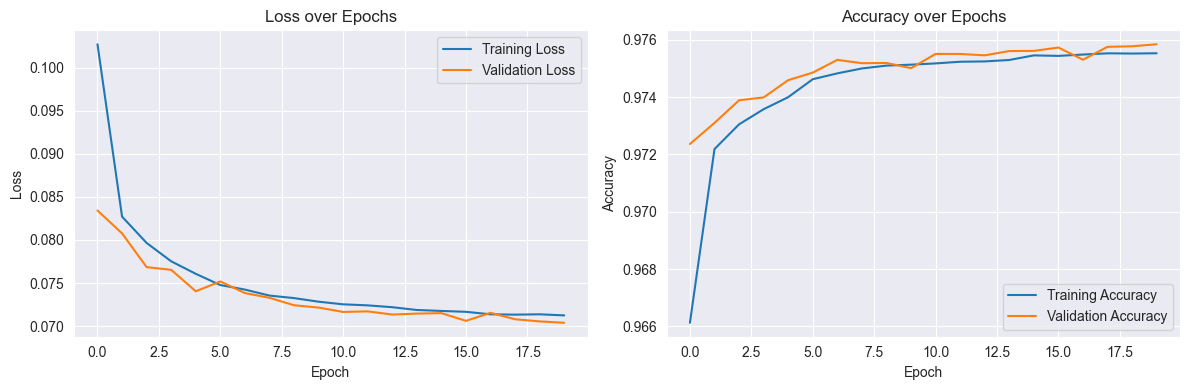

In [6]:
# Plotting Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('cnn_training_history.png')
# plt.show() # Use plt.show() in your notebook
print("Training history plot saved as cnn_training_history.png")

# Step 7: Testing, Evaluation, and Confusion Matrix

Test Loss: 0.0704
Test Accuracy: 0.9758
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 4s 185us/step


/Users/korijackson/SchoolRepos/Comp361Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/korijackson/SchoolRepos/Comp361Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/korijackson/SchoolRepos/Comp361Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1515
           1       0.48      0.35      0.41      5759
           2       0.66      0.70      0.68      3668
           3       0.34      0.03      0.06       386
           4       0.00      0.00      0.00       803
           5       0.00      0.00      0.00       539
           6       0.00      0.00      0.00       160
           7       0.00      0.00      0.00      4906
           8       0.55      0.92      0.69     13358
           9       1.00      0.97      0.99     64644
          10       0.00      0.00      0.00       528
          11       0.00      0.00      0.00        67
          12       0.99      1.00      0.99    665630
          13       0.00      0.00      0.00        52

    accuracy                           0.98    762015
   macro avg       0.29      0.28      0.27    762015
weighted avg       0.97      0.98      0.97    76

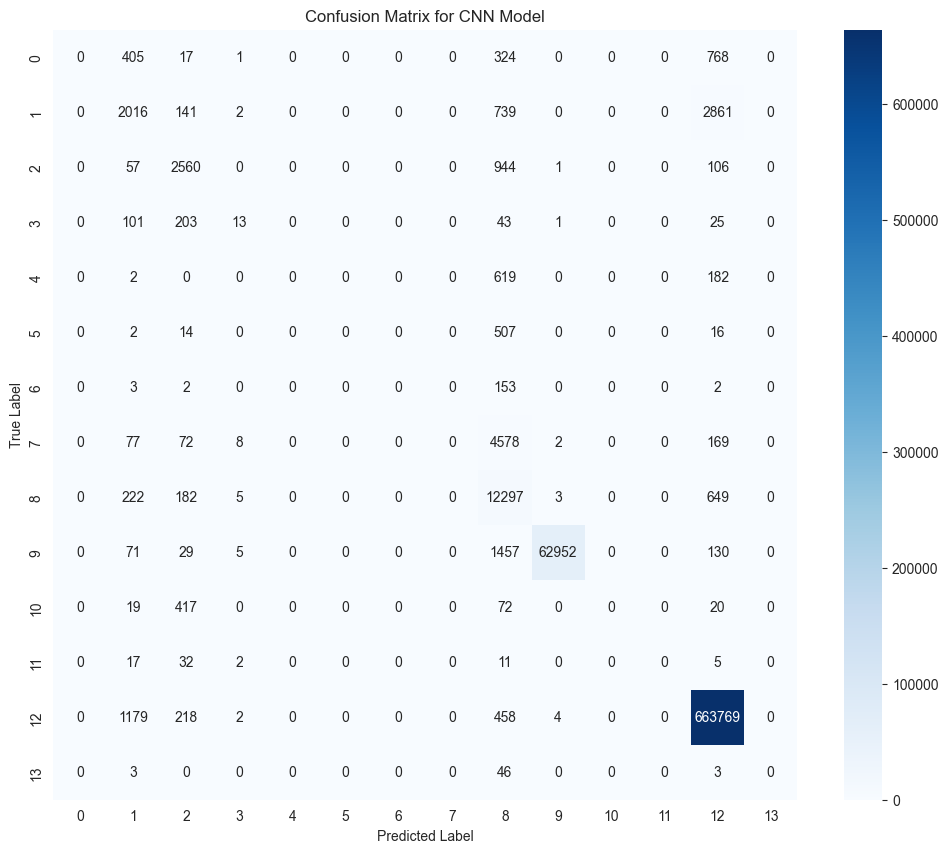

In [7]:
# --- 1. Evaluate Model on Test Set ---
loss, accuracy = cnn_model.evaluate(X_test_cnn, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- 2. Predict Classes ---
Y_pred_prob = cnn_model.predict(X_test_cnn)
Y_pred_int = np.argmax(Y_pred_prob, axis=1) # Convert probabilities to class integers
Y_true_int = np.argmax(Y_test, axis=1)      # Get true class integers

# (e.g., 0.0 -> '0.0', 1.0 -> '1.0') so the report can calculate their length.
class_names = [str(c) for c in label_encoder.classes_]

# --- 3. Classification Report ---
report = classification_report(Y_true_int, Y_pred_int, target_names=class_names)
print("\n--- Classification Report ---")
print(report)

# --- 4. Confusion Matrix Visualization ---
cm = confusion_matrix(Y_true_int, Y_pred_int)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix for CNN Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('cnn_confusion_matrix.png')
# plt.show() # Use plt.show() in your notebook
print("\nConfusion Matrix plot saved as cnn_confusion_matrix.png")